## 이상치 처리 기능 정리

### 이상치 탐지 방법
- **IQR(Interquartile Range) 방식**:
  - 데이터의 1사분위수(Q1)와 3사분위수(Q3)를 기준으로 이상치를 탐지
- **Z-score 방식**:
  - 데이터의 평균과 표준편차를 기준으로 이상치를 탐지

---

### 이상치 처리 방법
- **cap**: 이상치를 상한/하한값으로 제한
- **remove**: 이상치가 있는 행을 삭제
- **mean**: 이상치를 평균값으로 대체
- **median**: 이상치를 중앙값으로 대체

---

### 1. `OutlierHandler` 클래스
- 데이터 로드 및 이상치 탐지
- 2가지 방법(IQR, Z-score)으로 이상치 탐지
- 이상치에 대한 다양한 처리(cap, remove, mean, median) 지원
- 처리 히스토리 저장 및 취소(undo) 기능 제공
- 결과 저장 및 JSON 형식 변환 기능 제공

---

### 2. `api_handle_outliers` 함수
- 웹 서비스 API 응답 형식 시뮬레이션
- 처리 상태, 메시지, 변경된 데이터 반환

---

### 사용자 흐름
1. 사용자가 데이터를 업로드
2. 이상치 탐지 방법(IQR 또는 Z-score) 선택
3. 이상치를 처리할 방법(cap, remove, mean, median) 선택
4. 백엔드 API 요청 → 이상치 처리 → 변경된 행, 원래 행, 인덱스 반환
5. '데이터 미리보기' 섹션에 변경된 행 표시
6. 사용자는 작업을 취소할 수 있음 (undo 시 이전 상태로 복원)

---
### 중요) json 파일에 포함된 정보
-> 원래 행, 바뀐 행, 행 인덱스
1. outlier_indices: 이상치로 탐지되어 변경된 행의 인덱스 번호들 (27, 88, 118 등)
2. original_rows: 변경 전 원래 행들의 모든 정보

    각 행에는 PassengerId부터 Embarked까지 모든 컬럼 값이 포함됨
    예: PassengerId가 28인 승객의 Fare가 원래 263.0이었음


3. changed_rows: 변경 후 바뀐 행들의 모든 정보

각 행에는 PassengerId부터 Embarked까지 모든 컬럼 값이 포함됨
예: PassengerId가 28인 승객의 Fare가 14.4542로 변경됨

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from datetime import datetime
from scipy import stats

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)    # 마이너스(-) 깨짐 방지


In [2]:
class OutlierDetector:
    def __init__(self, data_path=None, df=None):
        """
        이상치 탐지 및 처리 클래스 초기화
        
        Parameters:
        -----------
        data_path : str, optional
            데이터 파일 경로
        df : pandas.DataFrame, optional
            직접 데이터프레임 전달 시 사용
        """
        if df is not None:
            self.df = df.copy()
        elif data_path is not None:
            self.df = pd.read_csv(data_path)
        else:
            raise ValueError("데이터 파일 경로 또는 데이터프레임을 제공해야 합니다.")
            
        # 데이터 처리 히스토리 저장
        self.history = []
        # 원본 데이터 백업
        self.original_df = self.df.copy()
        
        # 결과 저장 디렉토리 생성
        self.result_dir = 'preprocessing_results'
        os.makedirs(self.result_dir, exist_ok=True)
    
    def detect_outliers_iqr(self, column, multiplier=1.5):
        """
        IQR 방식으로 이상치 탐지
        
        Parameters:
        -----------
        column : str
            이상치를 탐지할 컬럼 이름
        multiplier : float, default=1.5
            IQR에 곱할 값 (일반적으로 1.5 사용)
            
        Returns:
        --------
        dict
            이상치 탐지 결과 정보
        """
        if column not in self.df.columns:
            return {"error": f"컬럼 '{column}'이 데이터에 존재하지 않습니다."}
            
        # 컬럼이 숫자형인지 확인
        if not pd.api.types.is_numeric_dtype(self.df[column]):
            return {"error": f"'{column}' 컬럼은 숫자형이 아니므로 이상치 탐지가 불가능합니다."}
            
        # 결측치가 있는 행은 제외
        valid_data = self.df[column].dropna()
        
        # IQR 계산
        Q1 = valid_data.quantile(0.25)
        Q3 = valid_data.quantile(0.75)
        IQR = Q3 - Q1
        
        # 이상치 경계값 계산
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        
        # 이상치 인덱스 탐지
        outlier_indices = self.df[(self.df[column] < lower_bound) | 
                                 (self.df[column] > upper_bound)].index.tolist()
        
        return {
            "method": "IQR",
            "column": column,
            "multiplier": multiplier,
            "Q1": float(Q1),
            "Q3": float(Q3),
            "IQR": float(IQR),
            "lower_bound": float(lower_bound),
            "upper_bound": float(upper_bound),
            "outlier_indices": outlier_indices,
            "outlier_count": len(outlier_indices),
            "outlier_ratio": len(outlier_indices) / len(valid_data) * 100,
            "outlier_values": self.df.loc[outlier_indices, column].tolist() if outlier_indices else []
        }
    
    def detect_outliers_zscore(self, column, threshold=3.0):
        """
        Z-score 방식으로 이상치 탐지
        
        Parameters:
        -----------
        column : str
            이상치를 탐지할 컬럼 이름
        threshold : float, default=3.0
            Z-score 임계값 (일반적으로 3.0 사용)
            
        Returns:
        --------
        dict
            이상치 탐지 결과 정보
        """
        if column not in self.df.columns:
            return {"error": f"컬럼 '{column}'이 데이터에 존재하지 않습니다."}
            
        # 컬럼이 숫자형인지 확인
        if not pd.api.types.is_numeric_dtype(self.df[column]):
            return {"error": f"'{column}' 컬럼은 숫자형이 아니므로 이상치 탐지가 불가능합니다."}
            
        # 결측치가 있는 행은 제외
        valid_data = self.df[column].dropna()
        
        # Z-score 계산
        z_scores = stats.zscore(valid_data)
        
        # 이상치 인덱스 탐지 (원본 데이터프레임 인덱스와 매핑)
        valid_indices = valid_data.index
        outlier_mask = np.abs(z_scores) > threshold
        outlier_indices = valid_indices[outlier_mask].tolist()
        
        return {
            "method": "Z-score",
            "column": column,
            "threshold": threshold,
            "mean": float(valid_data.mean()),
            "std": float(valid_data.std()),
            "outlier_indices": outlier_indices,
            "outlier_count": len(outlier_indices),
            "outlier_ratio": len(outlier_indices) / len(valid_data) * 100,
            "outlier_values": self.df.loc[outlier_indices, column].tolist() if outlier_indices else []
        }
    
    def visualize_outliers(self, column, method='both'):
        """
        이상치 시각화
        
        Parameters:
        -----------
        column : str
            시각화할 컬럼 이름
        method : str, default='both'
            사용할 방법 ('iqr', 'zscore', 'both')
            
        Returns:
        --------
        None
            그래프 출력
        """
        if column not in self.df.columns:
            print(f"Error: 컬럼 '{column}'이 데이터에 존재하지 않습니다.")
            return
            
        # 컬럼이 숫자형인지 확인
        if not pd.api.types.is_numeric_dtype(self.df[column]):
            print(f"Error: '{column}' 컬럼은 숫자형이 아니므로 시각화가 불가능합니다.")
            return
            
        plt.figure(figsize=(15, 6))
        
        # IQR 방법 시각화
        if method.lower() in ['iqr', 'both']:
            iqr_result = self.detect_outliers_iqr(column)
            if "error" not in iqr_result:
                plt.subplot(1, 2, 1)
                sns.boxplot(y=self.df[column])
                plt.title(f'IQR 방식 이상치 탐지 - {column}\n'
                         f'이상치 수: {iqr_result["outlier_count"]} '
                         f'({iqr_result["outlier_ratio"]:.2f}%)')
                plt.axhline(y=iqr_result["lower_bound"], color='r', linestyle='--', label='Lower Bound')
                plt.axhline(y=iqr_result["upper_bound"], color='r', linestyle='--', label='Upper Bound')
                plt.legend()
                
        # Z-score 방법 시각화
        if method.lower() in ['zscore', 'both']:
            zscore_result = self.detect_outliers_zscore(column)
            if "error" not in zscore_result:
                plt.subplot(1, 2, 2)
                sns.histplot(self.df[column], kde=True)
                plt.title(f'Z-score 방식 이상치 탐지 - {column}\n'
                         f'이상치 수: {zscore_result["outlier_count"]} '
                         f'({zscore_result["outlier_ratio"]:.2f}%)')
                
                # 이상치 표시
                for idx in zscore_result["outlier_indices"]:
                    plt.axvline(x=self.df.loc[idx, column], color='r', alpha=0.1)
                
                # Z-score 임계값 표시
                mean = zscore_result["mean"]
                std = zscore_result["std"]
                threshold = zscore_result["threshold"]
                plt.axvline(x=mean + threshold * std, color='r', linestyle='--', label=f'+{threshold} std')
                plt.axvline(x=mean - threshold * std, color='r', linestyle='--', label=f'-{threshold} std')
                plt.legend()
                
        plt.tight_layout()
        plt.show()
        
    def handle_outliers(self, column, method='iqr', treatment='cap', save_history=True):
        """
        이상치 처리
        
        Parameters:
        -----------
        column : str
            처리할 컬럼 이름
        method : str, default='iqr'
            탐지 방법 ('iqr', 'zscore')
        treatment : str, default='cap'
            처리 방법 ('cap', 'remove', 'mean', 'median')
        save_history : bool, default=True
            처리 히스토리 저장 여부
            
        Returns:
        --------
        dict
            처리 결과 정보
        """
        # 이상치 탐지
        if method.lower() == 'iqr':
            detection_result = self.detect_outliers_iqr(column)
        elif method.lower() == 'zscore':
            detection_result = self.detect_outliers_zscore(column)
        else:
            return {"error": "유효하지 않은 탐지 방법입니다. 'iqr' 또는 'zscore'를 사용하세요."}
            
        if "error" in detection_result:
            return detection_result
            
        outlier_indices = detection_result["outlier_indices"]
        
        if not outlier_indices:
            return {"message": f"{column} 컬럼에서 이상치가 발견되지 않았습니다."}
            
        # 원래 데이터의 복사본 저장
        original_rows = self.df.loc[outlier_indices].copy()
        
        if treatment == 'cap':
            # 상한/하한값으로 제한
            if method.lower() == 'iqr':
                lower_bound = detection_result["lower_bound"]
                upper_bound = detection_result["upper_bound"]
                self.df.loc[self.df[column] < lower_bound, column] = lower_bound
                self.df.loc[self.df[column] > upper_bound, column] = upper_bound
            else:  # z-score
                mean = detection_result["mean"]
                std = detection_result["std"]
                threshold = detection_result["threshold"]
                lower_bound = mean - threshold * std
                upper_bound = mean + threshold * std
                self.df.loc[self.df[column] < lower_bound, column] = lower_bound
                self.df.loc[self.df[column] > upper_bound, column] = upper_bound
                
            description = f"{column} 컬럼의 이상치를 상한/하한값으로 제한"
            
        elif treatment == 'remove':
            # 이상치 제거 (행 삭제)
            self.df = self.df.drop(outlier_indices)
            description = f"{column} 컬럼의 이상치가 있는 행을 제거"
            
        elif treatment == 'mean':
            # 평균값으로 대체
            mean_value = self.df[column].mean()
            self.df.loc[outlier_indices, column] = mean_value
            description = f"{column} 컬럼의 이상치를 평균값({mean_value:.2f})으로 대체"
            
        elif treatment == 'median':
            # 중앙값으로 대체
            median_value = self.df[column].median()
            self.df.loc[outlier_indices, column] = median_value
            description = f"{column} 컬럼의 이상치를 중앙값({median_value:.2f})으로 대체"
            
        else:
            return {"error": "유효하지 않은 처리 방법입니다. 'cap', 'remove', 'mean', 'median' 중 하나를 사용하세요."}
            
        # 변경된 행
        changed_rows = self.df.loc[outlier_indices].copy() if treatment != 'remove' else None
        
        # 처리 결과
        result = {
            "column": column,
            "method": method,
            "treatment": treatment,
            "detection_result": detection_result,
            "description": description,
            "outlier_indices": outlier_indices,
            "original_rows": original_rows.to_dict('records') if isinstance(original_rows, pd.DataFrame) else None,
            "changed_rows": changed_rows.to_dict('records') if isinstance(changed_rows, pd.DataFrame) else None,
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
        
        # 히스토리 저장
        if save_history:
            self.history.append(result)
            # 결과 파일 저장
            self._save_result(result)
            
        return result
    
    def undo_last_operation(self):
        """가장 최근 처리 작업 취소"""
        if not self.history:
            return {"error": "취소할 작업이 없습니다."}
            
        # 가장 최근 작업 가져오기
        last_op = self.history.pop()
        column = last_op["column"]
        treatment = last_op["treatment"]
        
        if treatment == 'remove':
            # 이상치 제거 작업 취소 (행 복원)
            original_rows = pd.DataFrame.from_dict(last_op["original_rows"])
            self.df = pd.concat([self.df, original_rows]).sort_index()
            message = f"{column} 컬럼의 이상치 제거 작업이 취소되었습니다."
        else:
            # 다른 처리 작업 취소 (값 복원)
            for row in last_op["original_rows"]:
                idx = row["PassengerId"] - 1  # 타이타닉 데이터는 PassengerId가 1부터 시작하므로 조정
                self.df.loc[idx, column] = row[column]
            message = f"{column} 컬럼의 이상치 처리 작업이 취소되었습니다."
            
        return {
            "message": message,
            "restored_rows": last_op["original_rows"]
        }
    
    def get_numeric_columns(self):
        """숫자형 컬럼 목록 반환"""
        return self.df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    def get_current_data(self):
        """현재 데이터프레임 반환"""
        return self.df.copy()
    
    def get_history(self):
        """처리 히스토리 반환"""
        return self.history
    
    def reset_to_original(self):
        """원본 데이터로 초기화"""
        self.df = self.original_df.copy()
        self.history = []
        return {"message": "데이터가 원본 상태로 초기화되었습니다."}
    
    def _save_result(self, result):
        """처리 결과 저장"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{self.result_dir}/outlier_{result['column']}_{result['method']}_{result['treatment']}_{timestamp}.json"
        
        # JSON 직렬화 가능한 형태로 변환
        save_result = {
            "column": result["column"],
            "method": result["method"],
            "treatment": result["treatment"],
            "description": result["description"],
            "outlier_count": result["detection_result"]["outlier_count"],
            "outlier_ratio": result["detection_result"]["outlier_ratio"],
            "outlier_indices": result["outlier_indices"],
            "original_rows": result["original_rows"],
            "changed_rows": result["changed_rows"],
            "timestamp": result["timestamp"]
        }
        
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(save_result, f, ensure_ascii=False, indent=2)
            
        return filename
    
    def save_dataframe(self, filename=None):
        """현재 데이터프레임 저장"""
        if filename is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"{self.result_dir}/processed_data_{timestamp}.csv"
            
        self.df.to_csv(filename, index=False)
        return {"message": f"데이터가 '{filename}'에 저장되었습니다."}
    
    def export_as_json(self):
        """현재 데이터프레임을 JSON 형식으로 변환"""
        return {
            "data": self.df.to_dict('records'),
            "columns": list(self.df.columns),
            "shape": self.df.shape
        }


API 응답 시뮬레이션 함수

In [3]:
def api_handle_outliers(df, column, method, treatment):
    """
    이상치 처리 API 응답 시뮬레이션
    
    Parameters:
    -----------
    df : pandas.DataFrame
        데이터프레임
    column : str
        처리할 컬럼 이름
    method : str
        탐지 방법 ('iqr', 'zscore')
    treatment : str
        처리 방법 ('cap', 'remove', 'mean', 'median')
        
    Returns:
    --------
    dict
        API 응답 형식의 결과
    """
    detector = OutlierDetector(df=df)
    result = detector.handle_outliers(column, method, treatment)
    
    if "error" in result:
        return {
            "status": "error",
            "message": result["error"],
            "data": None
        }
    
    return {
        "status": "success",
        "message": result["description"],
        "data": {
            "column": column,
            "method": method,
            "treatment": treatment,
            "outlier_count": result["detection_result"]["outlier_count"],
            "outlier_ratio": result["detection_result"]["outlier_ratio"],
            "outlier_indices": result["outlier_indices"],
            "original_rows": result["original_rows"],
            "changed_rows": result["changed_rows"],
            "processed_df": detector.get_current_data().to_dict('records')
        }
    }

테스트 및 사용 예제

===== 타이타닉 데이터 이상치 탐지 및 처리 예제 =====

1. 숫자형 컬럼 목록: ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

2. Age 컬럼 이상치 탐지 (IQR 방식):
  - 이상치 수: 11개
  - 이상치 비율: 1.54%
  - 하한값: -6.69
  - 상한값: 64.81

3. Age 컬럼 이상치 탐지 (Z-score 방식):
  - 이상치 수: 2개
  - 이상치 비율: 0.28%

4. 이상치 시각화:


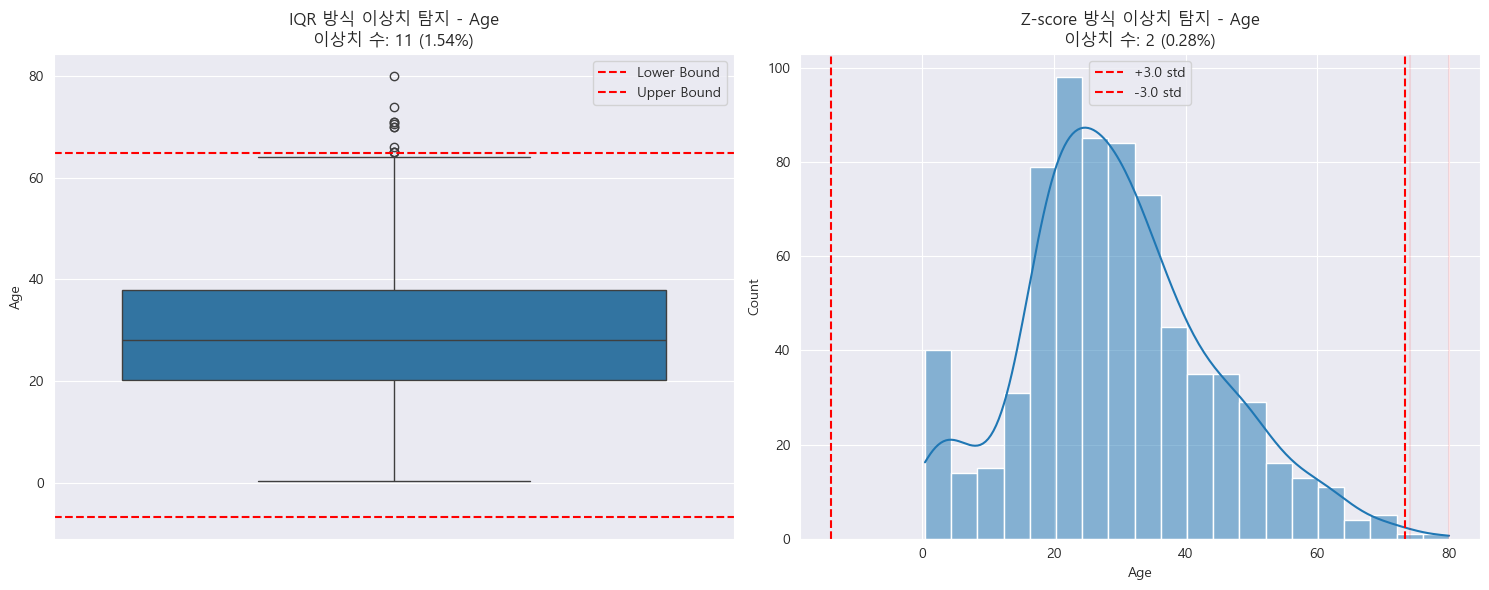

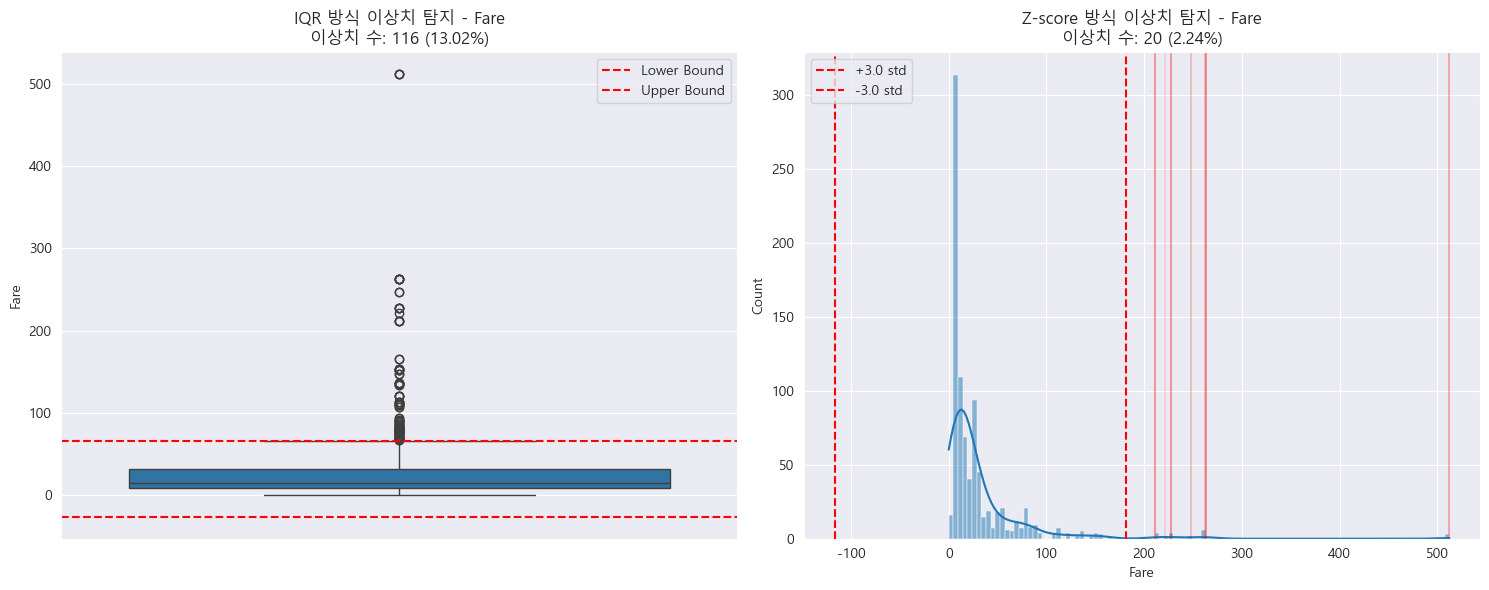


5. Fare 컬럼 이상치 처리 (IQR 방식, 상한/하한값으로 제한):
  - 처리 방법: Fare 컬럼의 이상치를 상한/하한값으로 제한
  - 처리된 이상치 수: 116

6. Age 컬럼 이상치 처리 (Z-score 방식, 평균값으로 대체):
  - 처리 방법: Age 컬럼의 이상치를 평균값(29.70)으로 대체
  - 처리된 이상치 수: 2

7. 처리 히스토리:
  작업 1: Fare 컬럼의 이상치를 상한/하한값으로 제한 (2025-04-27 02:01:01)
  작업 2: Age 컬럼의 이상치를 평균값(29.70)으로 대체 (2025-04-27 02:01:01)

8. API 응답 형식 예제:
  상태: success
  메시지: Fare 컬럼의 이상치를 중앙값(14.45)으로 대체
  처리된 이상치 수: 20

9. 마지막 작업 취소:
  메시지: Age 컬럼의 이상치 처리 작업이 취소되었습니다.

10. 처리된 데이터 저장:
  데이터가 'preprocessing_results/processed_data_20250427_020101.csv'에 저장되었습니다.

===== 테스트 완료 =====


In [6]:
if __name__ == "__main__":
    # 데이터 로드
    titanic_url = 'https://bit.ly/fc-ml-titanic'
    df = pd.read_csv(titanic_url)
    
    print("===== 타이타닉 데이터 이상치 탐지 및 처리 예제 =====")
    
    # 이상치 탐지 인스턴스 생성
    detector = OutlierDetector(df=df)
    
    # 숫자형 컬럼 목록 확인
    numeric_cols = detector.get_numeric_columns()
    print(f"\n1. 숫자형 컬럼 목록: {numeric_cols}")
    
    # 예제 1: Age 컬럼의 이상치 탐지 (IQR 방식)
    print("\n2. Age 컬럼 이상치 탐지 (IQR 방식):")
    age_outliers_iqr = detector.detect_outliers_iqr('Age')
    print(f"  - 이상치 수: {age_outliers_iqr['outlier_count']}개")
    print(f"  - 이상치 비율: {age_outliers_iqr['outlier_ratio']:.2f}%")
    print(f"  - 하한값: {age_outliers_iqr['lower_bound']:.2f}")
    print(f"  - 상한값: {age_outliers_iqr['upper_bound']:.2f}")
    
    # 예제 2: Age 컬럼의 이상치 탐지 (Z-score 방식)
    print("\n3. Age 컬럼 이상치 탐지 (Z-score 방식):")
    age_outliers_zscore = detector.detect_outliers_zscore('Age')
    print(f"  - 이상치 수: {age_outliers_zscore['outlier_count']}개")
    print(f"  - 이상치 비율: {age_outliers_zscore['outlier_ratio']:.2f}%")
    
    # 예제 3: 이상치 시각화
    print("\n4. 이상치 시각화:")
    detector.visualize_outliers('Age', 'both')
    detector.visualize_outliers('Fare', 'both')
    
    # 예제 4: Fare 컬럼의 이상치 처리 (IQR 방식, 상한/하한값으로 제한)
    print("\n5. Fare 컬럼 이상치 처리 (IQR 방식, 상한/하한값으로 제한):")
    result1 = detector.handle_outliers('Fare', 'iqr', 'cap')
    print(f"  - 처리 방법: {result1['description']}")
    print(f"  - 처리된 이상치 수: {len(result1['outlier_indices'])}")
    
    # 예제 5: Age 컬럼의 이상치 처리 (Z-score 방식, 평균값으로 대체)
    print("\n6. Age 컬럼 이상치 처리 (Z-score 방식, 평균값으로 대체):")
    result2 = detector.handle_outliers('Age', 'zscore', 'mean')
    print(f"  - 처리 방법: {result2['description']}")
    print(f"  - 처리된 이상치 수: {len(result2['outlier_indices'])}")
    
    # 예제 6: 히스토리 확인
    print("\n7. 처리 히스토리:")
    history = detector.get_history()
    for i, h in enumerate(history):
        print(f"  작업 {i+1}: {h['description']} ({h['timestamp']})")
    
    # 예제 7: API 응답 시뮬레이션
    print("\n8. API 응답 형식 예제:")
    api_response = api_handle_outliers(df, 'Fare', 'zscore', 'median')
    print(f"  상태: {api_response['status']}")
    print(f"  메시지: {api_response['message']}")
    print(f"  처리된 이상치 수: {len(api_response['data']['outlier_indices'])}")
    
    # 예제 8: 마지막 작업 취소
    print("\n9. 마지막 작업 취소:")
    undo_result = detector.undo_last_operation()
    print(f"  메시지: {undo_result['message']}")
    
    # 예제 9: 결과 저장
    print("\n10. 처리된 데이터 저장:")
    save_result = detector.save_dataframe()
    print(f"  {save_result['message']}")
    
    print("\n===== 테스트 완료 =====")